# FILA DE BANCOS

## Introdução
Este programa simula a chegada de clientes a um banco, que possui alguns postos de atendimento (caixas). A fila é única para todos os caixas.
Os tempos entre chegadas de clientes segue uma distribuição normal, continua discreta, contínua ou exponencial.
A duração do atendimento a um cliente no caixa segue uma distribuição normal. 

Ao final, você encontra algumas sugestões de melhorias neste programa, que você pode fazer como exercício.

**eventos** 

É uma lista de eventos programados, sendo que cada evento
pode ser:


*   -1 é o evento da chegada de um cliente ao banco
*   0, 1, 2 ... é o evento do término do atendimento de um cliente
no caixa 0, 1, 2, ...




**horario_eventos**

É a lista dos horários em que ocorrerão os eventos programados na lista **eventos**. 

**caixas**

É uma lista dos caixas (postos de atendimentos). Cada caixa pode estar em um dos seguintes estados:
*   "livre"
*   "ocupado"
*   "fechado"





**fila**

É uma lista que contém os horários de chegada nos clientes que comporão a fila de atendimento. Serve para podermos medir o tempo de espera em fila. 

**horario**

Variável inteira com o horário atual. O tempo é medido em segundos, contados a partir do instante 0 (instante em que a simulação começou a ser executada).

**tempos_espera**

Lista que registra o tempo de espera na fila de cada cliente que vem ao banco. Se o cliente não encontrou nenhuma fila, registra zero. Unidade é minutos (e não segundos!). 

In [1]:
import random # biblioteca para geração de números aleatórios
import time   # biblioteca que possui função para gerar espera no processamento
from matplotlib import pyplot as plt  # biblioteca gráfica
import numpy as np
import pandas as pd

class Fila():
    def __init__(
        self, 
        n_caixas: int = 3, 
        seed = 1,
        # Chegada
        t_chegada_media = 59,
        t_chegada_dp = 8,
        t_chegada_minimo = 40,
        t_chegada_maximo = 100,
        dist_chegada = 'gauss-norm',
        # Saida
        t_saida_media = 180,
        t_saida_dp = 30,
        p_preferencial = 0.1
        ):
        '''
        Simulacao de uma fila bancaria
        Parametros
        ----------
        n_caixa: numero de caixas no banco
        seed: seed aleatorio, inserir None para nao utilizar seed
        t_chegada_media: tempo medio de chegada (utilizado em 'gauss-norm' e 'exponencial')
        t_chegada_dp: desvio padrao do tempo de saida (utilizado em 'gauss-norm')
        t_chegada_minimo: tempo minimo do intervalo de chegada (utilizado em 'uniforme discreta' e 'uniforme continua')
        t_chegada_maximo: tempo maximo do imtervalo de chegada (utilizado em 'uniforme discreta' e 'uniforme continua')
        dist_chegada: tipo de distribuicao deve ser um de 'gauss-norm', 'uniforme discreta', 'uniforme continua' ou 'exponencial'
        t_saida_media: tempo medio do atendimento
        t_saida_dp: desvio padrao do atendimento
        '''
        
        if seed:
            random.seed(seed) # define semente fixa para geração de números pseudo-aleatórios


        #---------------------------------------------------------------------

        # Horário corrente (inteiro, em segundos) começa em zero.
        self.horario = 0  # segundos

        # A lista de ventos começa, de início, com um único evento: a chegada de um
        # cliente. Este evento ocorrerá no instante 0.
        self.eventos = [-1]
        self.log_eventos = []
        self.horario_eventos = [0]
        self.log_horarios_eventos = []
        self.preferencial = []
        self.log_preferencial = []

        # Aqui está o estado inicial dos postos de atendimento (caixas).
        self.caixas = ["livre"] * n_caixas

        # A fila de atendimento começa vazia (ninguém na fila). 
        self.fila = []
        self.log_fila = []

        # Não há registros de tempos de espera pelos clientes (ninguém chegou ainda!).
        self.tempos_espera = [] # segundos
        self.log_tempo_atendimentos = []
        
        # Funcao aleatoria distribuicao chegada
        if dist_chegada == 'gauss-norm':
            self.fn_chegada = lambda :random.gauss(mu = t_chegada_media, sigma = t_chegada_dp)
        elif dist_chegada == 'uniforme discreta':
            self.fn_chegada = lambda :random.randint(a = t_chegada_minimo, b = t_chegada_maximo)
        elif dist_chegada == 'uniforme continua':
            self.fn_chegada = lambda :random.uniform(a = t_chegada_minimo, b = t_chegada_maximo)
        elif dist_chegada == 'exponencial':
            self.fn_chegada = lambda :random.expovariate(lambd = 1/t_chegada_media)
        else:
            raise ValueError("dist_chegada desconhecido deve ser igual a 'gauss-norm', 'uniforme discreta', 'uniforme continua' ou 'exponencial'")
        
        # Funcao de distribuicao de saida
        self.fn_saida = lambda :random.gauss(t_saida_media, t_saida_dp)
        
        self.p_preferencial = p_preferencial
        
    def chegada(self, verbose = False):
        '''
        Chegada de um novo cliente ao banco
        A função chegada() não recebe enhum parâmtro e não devolve nenhum resultado.
        '''
        
        # Programa a chegada de um próximo cliente após um tempo aleatório. 
        self.eventos.append(np.random.binomial(1, 1 - 0.5) - 2)
        
        h = self.horario + self.fn_chegada() # normal, especificando média e dp
        
        self.horario_eventos.append(h)
        
        if verbose:
            print(f"Programado evento de chegada de novo cliente aos {h:.1f} segundos")

        # Se há caixa livre, programa o evento o término do atendimento de cliente
        # recém chegado neste caixa.
        # Se não há caixa livre, cliente vai para fila de espera. 
        if "livre" in self.caixas:            # verifica aqui se há caixa livre 
            
            i = self.caixas.index("livre")    # em havendo caixa livre, descobre qual caixa
            
            self.caixas[i] = "ocupado"        # o caixa passa a estar acupado agora
            
            self.eventos.append(i)            # gera evento do término do atendimento
            
            dur_atend = self.fn_saida()
            
            self.log_tempo_atendimentos.append(dur_atend)
            
            h = self.horario + dur_atend # normal, especificando média e dp
            
            self.horario_eventos.append(h)    # registra o horário programado para o final desse atendimento
                                         
            self.tempos_espera.append(0)      # registra a espera deste cliente (0 seg) 
            
            if verbose:
                
                print(f"Programado evento de final de atendimento no caixa {i} aos {h:.1f} segundos")
            
        else:
            
            self.fila.append(self.horario)
            
            self.preferencial.append(bool(np.random.binomial(1, self.p_preferencial)))
            
            # estando todos os caixas ocupados, 
                                         # põe cliente na fila (anota-se na fila o
                                         # o instante de chegada deste cliente)
            
                    
    def saida(self, i, verbose = False):
        '''
        Trata o eventos do término do atendimento do cliente no caixa i. 
        Se há cliente na fila, aloca-o neste caixa, programando o término do
        atendimento neste caixa. 
        A função saida(i) recebe, como parâmetro o número do caixa terminou de
        atender seis cliente. Mas a função nada retorna como resultado. 
        '''
        
        if len(self.fila) == 0:        # Caixa foi liberado, mas não há cliente
            
            self.caixas[i] = "livre"   # na fila --> muda status deste caixa para livre.
            
            #self.caixas[self.eventos[-1]] = 'livre'
            
        else:
            # Havendo cliente na fila, registra quantos minutos ele esperou
            # para ser atendido e registra essa informação. Retira o cliente da
            # fila. Programa o final do atendimento do cliente nesse caixa. 
            
            if True in self.preferencial and i == 0:
                if verbose:
                    print('Atendimento preferencial')
                pos = self.preferencial.index(True)
                self.log_preferencial.append(True)
            else:
                pos = 0
                self.log_preferencial.append(False)
            
            self.tempos_espera.append((self.horario - self.fila[pos])/60) # espera = agora - chegada
            
            # del self.fila[0]
            self.fila.pop(pos)
            self.preferencial.pop(pos)

            self.eventos.append(i)
            
            dur_atend = self.fn_saida()
            
            self.log_tempo_atendimentos.append(dur_atend)
            
            y = self.horario + dur_atend
            
            self.horario_eventos.append(y)
            
            if verbose:
                print(f"Programado evento de final de atendimento no caixa {i} aos {y:.1f} segundos")
            
    def proximo_evento(self, verbose = False):
        '''
        Descobre qual o próximo evento a tratar na lista de eventos.
        A função proximo_evento() não recebe parâmetros e devolve, como resposta,
        qual é o próximo evento (-1 = chegada de cliente, 0, 1, 2... = término de
        atendimento em um caixa). 
        Para tanto procura em horario-eventos o horário mais próximo (o menor deles). 
        Se há cliente na fila, aloca-o neste caixa,
        programando o término do atendimento neste caixa. 
        A lista de eventos nunca estará vazia, por construção. 
        Essa função retorna o tipo do próximo evento (-1, 0, 1, 2..). 
        '''
        
        pos = self.horario_eventos.index(min(self.horario_eventos)) # index do próximo evento
        
        evento = self.eventos[pos]                             # obtém evento
        
        self.horario = self.horario_eventos[pos]                    # obtém horário do evento
        
        if evento < 0:
            e = "chegada de cliente"
        else:
            e = "término de atendimento no caixa " + str(evento)
        
        if verbose:
            print(f"Tratando evento = {e}, horário do evento = {self.horario:.1f} segundos")
        
        self.log_eventos.append(
            self.eventos.pop(pos)
        )           # apaga o referido evento da lista de eventos
        
        self.log_horarios_eventos.append(
            self.horario_eventos.pop(pos)
        )    # apaga horário do evento na lista dos horários
        
        self.log_fila.append(len(self.fila))
        
        return evento               # devolve o evento para o programa principal
    
    def simulacao(self, horas: float = 1, verbose = False):
        
        while self.horario < 60 * 60 * horas:
        #for i in range(20):
            
            x = self.proximo_evento(verbose = verbose)
            
            if x < 0:
                
                self.chegada(verbose = verbose)
                
            else:  # é Saída

                self.saida(x, verbose = verbose)
                
            if verbose:
                print('-' * 90)
        
#         self.log_eventos += self.eventos
#         self.log_horarios_eventos += self.horario_eventos
        
    
    def print_status(self, condensed: bool = False):
        
        if condensed:
            
            print(
                f'horario: {self.horario}\t eventos: {self.eventos}\t horario_eventos: {np.round(self.horario_eventos,1)} \t caixas: {self.caixas}\t fila: {self.fila} \t tempos_espera: {self.tempos_espera}'
            )
            
        else:
            
            print(f"horario: {self.horario}", '\n')

            print(f"eventos: {self.eventos}", '\n')

            print(f"horario_eventos: {np.round(self.horario_eventos,1)}", '\n')

            print(f"caixas: {self.caixas}", '\n')

            print(f"fila: {self.fila}", '\n')

            print(f"tempos_espera: {self.tempos_espera}")
            
    def show_results(self):
        
        print(f"Tamanho da fila = {len(self.fila)}") # imprime tamanho da fila
        print(f"Caixas: {self.caixas}")             # imprime situação dos caixas
        print(f"Duracao: {self.horario/60/60:.2f} h")
        print(f"Total de clientes: {len(self.tempos_espera)}")
        
        print(f"- Tempo máximo de espera na fila: {max(self.tempos_espera):.1f} min")
        print(f"- Tempo médio de espera na fila: {sum(self.tempos_espera)/len(self.tempos_espera):.1f} min")
        
        print('-'*80)
        
        # gera histograma dos tempos de espera na fila
        plt.hist(self.tempos_espera, 
                 #bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
                )
        plt.title('Histograma dos tempos de espera na fila')
        plt.xlabel("Tempo de espera na fila para ser atendido (minutos)")
        plt.ylabel("Contagem de clientes")
        plt.grid(True)
        plt.show()
        
        print('-'*80)
        
        # gera line plot dos tempos de espera na fila
        plt.plot(self.tempos_espera, color = "r")
        plt.title('Timeplot dos tempos de espera na fila')
        plt.xlabel("Número de ordem de chegada dos clientes")
        plt.ylabel("Tempo de espera na fila para ser atendido (minutos)")
        plt.grid(True)
        plt.grid(True)
        plt.show()
        
        print('-'*80)
        self.log = pd.DataFrame({'eventos': self.log_eventos, 'horarios': self.log_horarios_eventos})
        plt.title('Intervalo de chegadas')
        self.log[self.log.eventos == -1].horarios.diff().plot.hist()
        plt.grid(True)
        plt.show()
        
        print('-'*80)
        plt.title('Tempo de atendimentos')
        plt.hist(self.log_tempo_atendimentos)
        plt.grid(True)
        plt.show()
        
        print('-'*80)
        plt.plot(self.log_fila, color = "r")
        plt.title('Tamanho da Fila')
        plt.xlabel("Número de ordem de chegada dos clientes")
        plt.ylabel("Tamanho da Fila")
        plt.grid(True)
        plt.grid(True)
        plt.show()
        

### Criar simulador

In [2]:
f = Fila(
    n_caixas = 4,
    t_chegada_media = 50,
    t_chegada_dp = 8,
    t_chegada_minimo = 40,
    t_chegada_maximo = 100,
    dist_chegada = 'gauss-norm', # 'gauss-norm', 'uniforme discreta', 'uniforme continua' ou 'exponencial'
    t_saida_media = 160,
    t_saida_dp = 30,
    p_preferencial = 0.1
)

### Simulação com print de cada etapa

In [66]:
f.simulacao(horas = .1, verbose=True)

Tratando evento = chegada de cliente, horário do evento = 0.0 segundos
Programado evento de chegada de novo cliente aos 60.3 segundos
Programado evento de final de atendimento no caixa 0 aos 203.5 segundos
------------------------------------------------------------------------------------------
Tratando evento = chegada de cliente, horário do evento = 60.3 segundos
Programado evento de chegada de novo cliente aos 110.8 segundos
Programado evento de final de atendimento no caixa 1 aos 197.4 segundos
------------------------------------------------------------------------------------------
Tratando evento = chegada de cliente, horário do evento = 110.8 segundos
Programado evento de chegada de novo cliente aos 152.1 segundos
Programado evento de final de atendimento no caixa 2 aos 271.8 segundos
------------------------------------------------------------------------------------------
Tratando evento = chegada de cliente, horário do evento = 152.1 segundos
Programado evento de chegada de

### Simulação

In [3]:
f.simulacao(horas = 8)

### Mostrar Resultados

Tamanho da fila = 0
Caixas: ['ocupado', 'ocupado', 'ocupado', 'livre']
Duracao: 8.01 h
Total de clientes: 577
- Tempo máximo de espera na fila: 0.5 min
- Tempo médio de espera na fila: 0.0 min
--------------------------------------------------------------------------------


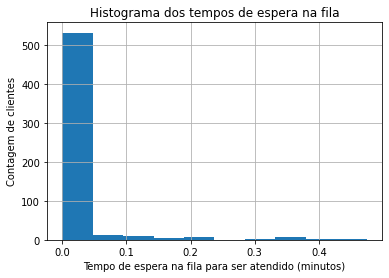

--------------------------------------------------------------------------------


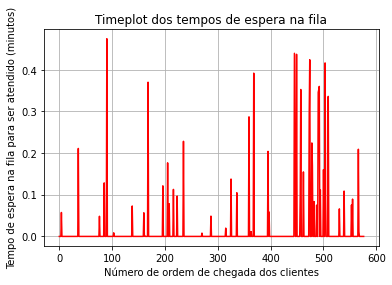

--------------------------------------------------------------------------------


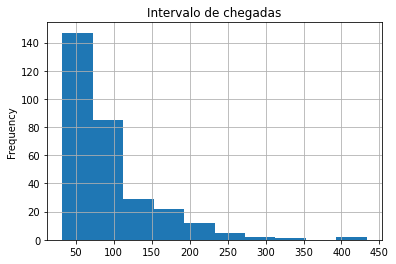

--------------------------------------------------------------------------------


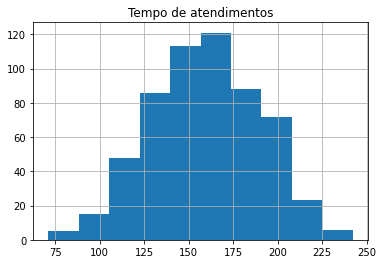

--------------------------------------------------------------------------------


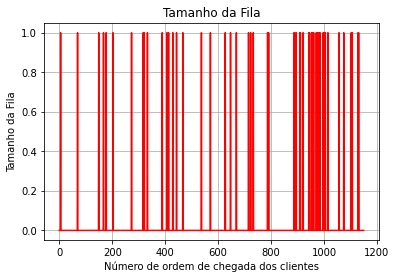

In [4]:
f.show_results()